In [1]:
import os, sys, time, math, torch
import numpy as np
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.discriminant_analysis import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU or CPU
f'Using device: {device}'

'Using device: cuda'

# I. Create Dataset

From train 80%, validation 20%
<br>
Modified to train 60%, validation 20%, test 20% => Using 'simple holdout validation'
<br>
Create a moving window which overlaps the Input(20 days) and Output(5 days) by 2 days to create dataset

Reference:
[Time series prediction](https://peaceful0907.medium.com/time-series-prediction-lstm%E7%9A%84%E5%90%84%E7%A8%AE%E7%94%A8%E6%B3%95-ed36f0370204)

![moving_window](moving_window.png)

In [2]:
def create_sequences(data, n_past, n_forecast, col_index):
    X, Y = [], []
    L = len(data)
    for i in range(L-(n_past+n_forecast)): # 1 day every step: i = 0, 1, 2, ..., L - (n_past + n_forecast)
        X.append(data[i:i+n_past]) # Input Sequence, using n_past days as input
        Y.append(data[i+n_past-2:i+n_past+n_forecast-2][:,col_index]) # Output Sequence with 2 days overlap Input Sequence

    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y)).unsqueeze(-1)

In [3]:
def preprocess(data_trend, train_ratio, val_ratio, n_past, n_forecast, col_index):
    scaler = StandardScaler()
    data_trend = scaler.fit_transform(data_trend) # standardization

    train_index = int(len(data_trend)*train_ratio)
    val_index = int(train_index+len(data_trend)*val_ratio)

    train_data = data_trend[:train_index]
    val_data = data_trend[train_index:val_index]
    test_data = data_trend[val_index:]

    print(f'train_data is data_trend[:{train_index}], shape is {train_data.shape}')
    print(f'val_data is data_trend[{train_index}:{val_index}], shape is {val_data.shape}')
    print(f'test_data is data_trend[:{val_index}], shape is {test_data.shape}')

    X_train, Y_train = create_sequences(train_data, n_past, n_forecast, col_index)
    X_val, Y_val = create_sequences(val_data, n_past, n_forecast, col_index)
    X_test, Y_test = create_sequences(test_data, n_past, n_forecast, col_index)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler

In [4]:
df = pd.read_csv('2330.TW.csv')
data = df[[c for c in df.columns if c not in ['Date', 'Adj Close']]].values

# 0: Open, 1: High, 2: Low, 3: Close, 4: Volume => 5 features to predict 'Close'
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = \
    preprocess(data, train_ratio=0.6, val_ratio=0.2, n_past=20, n_forecast=5, col_index=3) # col_index = 3

batch_size = 32

train_set = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_set = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_set = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

len(train_dataloader), len(test_dataloader), len(val_dataloader)

train_data is data_trend[:568], shape is (568, 5)
val_data is data_trend[568:757], shape is (189, 5)
test_data is data_trend[:757], shape is (191, 5)


(17, 6, 6)

In [5]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([543, 20, 5]),
 torch.Size([543, 5, 1]),
 torch.Size([164, 20, 5]),
 torch.Size([164, 5, 1]),
 torch.Size([166, 20, 5]),
 torch.Size([166, 5, 1]))

# II. Build Model

Transformer-Decoder Architecture

Reference:
[Transformers for Time-series Forecasting](https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820)

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # input and output shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:,:x.size(1)]

        return self.dropout(x)

In [7]:
class Transformer(nn.Module):
    def __init__(self, d_model, nhead, dropout, num_layers):
        super(Transformer, self).__init__()

        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_decoder = torch.nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.create_probability_output = torch.nn.Linear(d_model, 1)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.create_probability_output.weight.data.uniform_(-initrange, initrange)
        self.create_probability_output.bias.data.zero_()

    def forward(self, src, tgt):
        # print('Transformer source and target shapes:', src.shape, tgt.shape)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1]) # shape is adaptive to the input when training/predicting
        memory = self.transformer_encoder(src) # memory is the output of encoder
        decoder_output = self.transformer_decoder(tgt.to(device), memory.to(device), tgt_mask.to(device)) # the decoder takes in the tgt, memory, and tgt_mask
        output = self.create_probability_output(decoder_output) # forecast
        return output

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.expansion_input = torch.nn.Linear(in_features=5, out_features=512)
        self.expansion_output = torch.nn.Linear(in_features=1, out_features=512)

        self.positional_encoding_input = PositionalEncoding(d_model=512, dropout=0.1, max_len=20)
        self.positional_encoding_output = PositionalEncoding(d_model=512, dropout=0.1, max_len=5)

        self.transformer = Transformer(d_model=512, nhead=8, dropout=0.1, num_layers=2)

    def forward(self, src, tgt):
        src = self.expansion_input(src)
        tgt = self.expansion_output(tgt)

        src = self.positional_encoding_input(src)
        tgt = self.positional_encoding_output(tgt)

        output = self.transformer(src, tgt)
        return output

# III. Train Model

Model Inference

Reference:
[influenza_transformer](https://github.com/KasperGroesLudvigsen/influenza_transformer/tree/main)

In [9]:
### Progress bar from Keras API ###

class Progbar(object):
	def __init__(self,
				target,
				width=30,
				interval=0.05,
				stateful_metrics=None,
				unit_name='step'):
		self.target = target
		self.width = width
		self.interval = interval
		self.unit_name = unit_name
		if stateful_metrics:
			self.stateful_metrics = set(stateful_metrics)
		else:
			self.stateful_metrics = set()

		self._dynamic_display = ((hasattr(sys.stdout, 'isatty') and
								sys.stdout.isatty()) or
								'ipykernel' in sys.modules or
								'posix' in sys.modules or
								'PYCHARM_HOSTED' in os.environ)
		self._total_width = 0
		self._seen_so_far = 0
		self._values = {}
		self._values_order = []
		self._start = time.time()
		self._last_update = 0

		self._time_after_first_step = None

	def update(self, current, values=None, finalize=None):
		if finalize is None:
			if self.target is None:
				finalize = False
			else:
				finalize = current >= self.target

		values = values or []
		for k, v in values:
			if k not in self._values_order:
				self._values_order.append(k)
			if k not in self.stateful_metrics:
				value_base = max(current - self._seen_so_far, 1)
				if k not in self._values:
					self._values[k] = [v * value_base, value_base]
				else:
					self._values[k][0] += v * value_base
					self._values[k][1] += value_base
			else:
				self._values[k] = [v, 1]
		self._seen_so_far = current

		now = time.time()
		info = ' - %.0fs' % (now - self._start)
		if True:
			if now - self._last_update < self.interval and not finalize:
				return

			prev_total_width = self._total_width
			if self._dynamic_display:
				sys.stdout.write('\b' * prev_total_width)
				sys.stdout.write('\r')
			else:
				sys.stdout.write('\n')

			if self.target is not None:
				numdigits = int(np.log10(self.target)) + 1
				bar = ('%' + str(numdigits) + 'd/%d [') % (current, self.target)
				prog = float(current) / self.target
				prog_width = int(self.width * prog)
				if prog_width > 0:
					bar += ('=' * (prog_width - 1))
					if current < self.target:
						bar += '>'
					else:
						bar += '='
				bar += ('.' * (self.width - prog_width))
				bar += ']'
			else:
				bar = '%7d/Unknown' % current

			self._total_width = len(bar)
			sys.stdout.write(bar)

			time_per_unit = self._estimate_step_duration(current, now)

			if self.target is None or finalize:
				if time_per_unit >= 1 or time_per_unit == 0:
					info += ' %.0fs/%s' % (time_per_unit, self.unit_name)
				elif time_per_unit >= 1e-3:
					info += ' %.0fms/%s' % (time_per_unit * 1e3, self.unit_name)
				else:
					info += ' %.0fus/%s' % (time_per_unit * 1e6, self.unit_name)
			else:
				eta = time_per_unit * (self.target - current)
				if eta > 3600:
					eta_format = '%d:%02d:%02d' % (eta // 3600,
												(eta % 3600) // 60, eta % 60)
				elif eta > 60:
					eta_format = '%d:%02d' % (eta // 60, eta % 60)
				else:
					eta_format = '%ds' % eta

				info = ' - ETA: %s' % eta_format

			for k in self._values_order:
				info += ' - %s:' % k
				if isinstance(self._values[k], list):
					avg = np.mean(self._values[k][0] / max(1, self._values[k][1]))
					if abs(avg) > 1e-3:
						info += ' %.4f' % avg
					else:
						info += ' %.4e' % avg
				else:
					info += ' %s' % self._values[k]

			self._total_width += len(info)
			if prev_total_width > self._total_width:
				info += (' ' * (prev_total_width - self._total_width))

			if finalize:
				info += '\n'

			sys.stdout.write(info)
			sys.stdout.flush()

		self._last_update = now

	def _estimate_step_duration(self, current, now):
		if current:
			if self._time_after_first_step is not None and current > 1:
				time_per_unit = (now - self._time_after_first_step) / (current - 1)
			else:
				time_per_unit = (now - self._start) / current

			if current == 1:
				self._time_after_first_step = now
			return time_per_unit
		else:
			return 0

In [10]:
### training module ###

def train(model, progbar, train_dataloader, criterion, optimizer):
    train_loss_per_epoch = []

    model.train()  # turn on the train mode

    for i, (source, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        prediction = model(source.to(device), target.to(device))
        loss = criterion(prediction.to(device), target.to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7) # prevent gradient explosion
        optimizer.step()
        train_loss_per_epoch.append(loss.item())

        progbar.update(i, values=[('loss', loss.item())])

    train_loss = sum(train_loss_per_epoch) / len(train_loss_per_epoch)

    return train_loss

In [11]:
### inference module ###

def run_encoder_decoder_inference(model, source, n_forecast, device):
    target_seq_dim = 1 # dimension of a batched model input that contains the target sequence values
    target = source[:, -1, 3] # tgt is equal to the last value of src
    target = target.unsqueeze(-1).unsqueeze(-1)

    # Iteratively concatenate tgt with the first element in the prediction
    for _ in range(n_forecast-1):
        # make prediction
        prediction = model(source.to(device), target.to(device))

        last_predicted_value = prediction[:, -1, :]
        last_predicted_value = last_predicted_value.unsqueeze(-1) # tgt's size increases by 1 at each step

        # the last element in the model's prediction is iteratively concatenated with tgt
        target = torch.cat((target.to(device), last_predicted_value.to(device)), target_seq_dim)
        # print('target shape: ', target.shape, 'last_predicted_value shape: ', last_predicted_value)

    # tgt will have tgt seq_len and final prediction will be made
    # make final prediction
    final_prediction = model(source.to(device), target.to(device))

    # return final_prediction
    return final_prediction

In [12]:
### validation module ###

def validation(model, val_dataloader, criterion, device):
    val_loss_per_epoch = []

    model.eval() # turn on the evaluation mode

    with torch.no_grad():
        for source, target in val_dataloader:
            n_forecast = target.shape[1]
            prediction = run_encoder_decoder_inference(model, source, n_forecast, device)
            loss = criterion(prediction.to(device), target.to(device))
            val_loss_per_epoch.append(loss.item())

    val_loss = sum(val_loss_per_epoch) / len(val_loss_per_epoch)

    return val_loss

# IV. Main function

In [13]:
### initialize variables ###

lr = 1e-4
epochs = 50
min_val_loss = float(torch.inf)

total_train_loss = []
total_val_loss = []

best_model = 'model.pth'

In [14]:
### initialize model ###

model = Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95) # decay the learning rate by 0.95 every epoch

In [15]:
### training loop ###

for epoch in range(epochs):
    n_batches = len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}')
    progbar = Progbar(target=n_batches)

    train_loss = train(model, progbar, train_dataloader, criterion, optimizer)
    val_loss = validation(model, val_dataloader, criterion, device)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    progbar.update(n_batches, values=[('val_loss', val_loss)])

    if val_loss < min_val_loss:
        torch.save(model.state_dict(), 'model.pth')
        min_val_loss = val_loss

    scheduler.step()

Epoch 1/50
17/17 [==============================] - 1s 47ms/step - loss: 8.1220 - val_loss: 0.6252
Epoch 2/50
17/17 [==============================] - 1s 30ms/step - loss: 2.9529 - val_loss: 0.1475
Epoch 3/50
17/17 [==============================] - 1s 30ms/step - loss: 0.1048 - val_loss: 0.8669
Epoch 4/50
17/17 [==============================] - 0s 29ms/step - loss: 0.1249 - val_loss: 0.0599
Epoch 5/50
17/17 [==============================] - 1s 31ms/step - loss: 0.3164 - val_loss: 0.4705
Epoch 6/50
17/17 [==============================] - 1s 31ms/step - loss: 0.3316 - val_loss: 0.3874
Epoch 7/50
17/17 [==============================] - 1s 31ms/step - loss: 0.5839 - val_loss: 0.0593
Epoch 8/50
17/17 [==============================] - 0s 27ms/step - loss: 0.4931 - val_loss: 1.9373
Epoch 9/50
17/17 [==============================] - 1s 31ms/step - loss: 0.0781 - val_loss: 0.4680
Epoch 10/50
17/17 [==============================] - 1s 31ms/step - loss: 0.1949 - val_loss: 0.0660
Epoch 11/

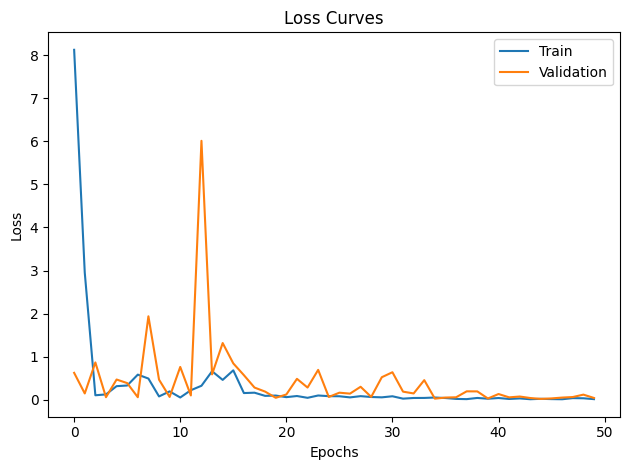

In [16]:
### plot loss module ###

plt.plot(total_train_loss, label='Train')
plt.plot(total_val_loss, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('Loss Curves.png')

# V. Result

In [17]:
### average price module ###

# averaging the overlapping 4 days forecast

def average_price(source):
    batch_size = source.shape[0]
    seq_len = source.shape[1]
    total_day = batch_size + seq_len - 1
    pointer = 0
    count_list = []

    for i in range(total_day):
        count = 0
        if i < seq_len - 1:
            path = i
            for k in range(i + 1):
                count += source[k][path]
                path -= 1
            count_list.append(count / (i + 1))
        elif i > total_day - seq_len:
            b = batch_size - (total_day - i)
            path = seq_len - 1
            for l in range(b, total_day - i + b):
                count += source[l][path]
                path -= 1
            count_list.append(count / (total_day - i))
        else:
            path = seq_len - 1
            for j in range(pointer, seq_len + pointer):
                count += source[j][path]
                path -= 1
            pointer += 1
            count_list.append(count / seq_len)

    count_array = np.array(count_list)
    return count_array

In [18]:
### testing module ###

model = Model().to(device)
model.load_state_dict(torch.load(f'model.pth'))

initialized = False

with torch.no_grad():

    model.eval() # turn on the evaluation mode

    for source, target in test_dataloader:
        n_forecast = target.shape[1]
        outputs = run_encoder_decoder_inference(model, source, n_forecast, device)

        outputs = outputs.squeeze(-1)
        target = target.squeeze(-1)

        outputs = np.sqrt(scaler.var_[3])*outputs.cpu().detach().numpy() + scaler.mean_[3]
        target = np.sqrt(scaler.var_[3])*target.cpu().detach().numpy() + scaler.mean_[3]

        if not initialized:
            all_outputs = outputs
            all_target = target
            initialized = True
        else:
            all_outputs = np.concatenate((all_outputs, outputs), axis=0)
            all_target = np.concatenate((all_target, target), axis=0)

# average out the stock price: 12345, 23456 => [1, avg(2345), 6] getting '123' days stock price
all_outputs = average_price(all_outputs)
all_target = average_price(all_target)

all_target = np.squeeze(all_target)
all_outputs = np.squeeze(all_outputs)

In [19]:
### calculate metrics ###

mae, mse, rmse = mean_absolute_error(all_target, all_outputs) \
    , mean_squared_error(all_target, all_outputs) \
    , np.sqrt(mean_squared_error(all_target, all_outputs))


correlation_matrix = np.corrcoef(all_target, all_outputs)
correlation_coefficient = correlation_matrix[0, 1]
correlation_coefficient

0.9707706098129119

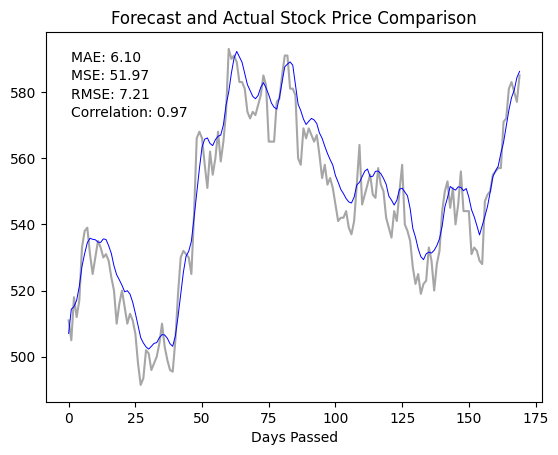

In [20]:
### plot result module ###

plt.clf()
plt.plot(all_target, color='grey', alpha=0.7)
plt.plot(all_outputs, color='blue', linewidth=0.7)
plt.title('Forecast and Actual Stock Price Comparison')
plt.xlabel('Days Passed')

plt.text(0.05, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.85, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.8, f'Correlation: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.savefig('Forecast and Actual Stock Price Comparison.png')